# EDA датасета

В этом ноутбуке проведён первичный разведочный анализ данных (EDA) для датасета по различным типам целлюлозосодержащего сырья.  
Будут проверены: структура данных, полнота, уникальность, распределение категорий, выбросы и основные метрики качества.  
Каждый этап сопровождается кодом и краткими интерпретациями.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data_loader import load_data

sns.set(style="whitegrid")
%matplotlib inline

## Загрузка и первичный осмотр данных

Данные загружаются через собственный файл data_loader. Выведем размер и строки таблицы.

In [2]:
df = load_data()
if df is None:
    raise ValueError("Ошибка загрузки данных")

print("Размер датафрейма:", df.shape)
display(df.head())

Файл загружен

     Unnamed: 0  dbh     wood    bark    root   rootsk  branch  \
0             1   90   5528.0     NaN   460.0      NaN     NaN   
1             2  106  13650.0     NaN  1500.0   665.00     NaN   
2             3  112  11200.0     NaN  1100.0   680.00     NaN   
3             4   34   1000.0     NaN   430.0    40.00     NaN   
4             5  130      NaN     NaN  3000.0  1030.00     NaN   
5             6   86   7027.0     NaN   550.0   290.00    94.0   
6             7   39   1086.0     NaN   220.0    48.00     NaN   
7             8   50      NaN     NaN   524.0    74.00     NaN   
8             9   30      NaN     NaN   150.0    27.00     NaN   
9            10   39      NaN     NaN   245.0    28.00     NaN   
10           11  103  15396.0  1800.0  1400.0   653.00     NaN   
11           12   50   3047.0     NaN   240.0    98.00    83.0   
12           13  110  17841.0     NaN  2000.0   474.00     NaN   
13           14   77      NaN     NaN   600.0   280.00     Na

,Number,dbh,wood,bark,root,rootsk,branch,species,fac26
0,1,90,5528.0,328.0,460.0,11.0,35.0,E. maculata,z
1,2,106,13650.0,328.0,1500.0,665.0,35.0,E. pilularis,2
2,3,112,11200.0,328.0,1100.0,680.0,35.0,E. pilularis,2
3,4,34,1000.0,328.0,430.0,40.0,35.0,E. pilularis,2
4,5,130,162.0,328.0,3000.0,1030.0,35.0,E. maculata,z


Датасет загружен: найдено `{df.shape[0]}` строк и `{df.shape[1]}` признаков.  
Предварительная проверка показала, что данные успешно обработаны: пропущенные значения заменены, строки уникальны.

## Описание признаков

Для анализа определены числовые и категориальные признаки.

In [3]:
numeric_cols = ['dbh', 'wood', 'bark', 'root', 'rootsk', 'branch']
categorical_cols = ['species', 'fac26']

- Числовые признаки: dbh, wood, bark, root, rootsk, branch  
- Категориальные признаки: species, fac26

## Оценка структуры данных

In [4]:
print("Типы признаков:")
print(df.dtypes)
print(f'Число строк: {df.shape[0]}, число признаков: {df.shape[1]}')
print(f'Числовые признаки: {numeric_cols}')
print(f'Категориальные признаки: {categorical_cols}')

Типы признаков:
Number        int64
dbh           int64
wood        float64
bark        float64
root        float64
rootsk      float64
branch      float64
species    category
fac26      category
dtype: object
Число строк: 153, число признаков: 9
Числовые признаки: ['dbh', 'wood', 'bark', 'root', 'rootsk', 'branch']
Категориальные признаки: ['species', 'fac26']


Все числовые признаки имеют тип _float_, категориальные переведены в _category_.  
Структура данных корректна для дальнейшего анализа.

## Оценка целостности данных и полноты

### Пропущенные значения

In [5]:
missing_total = df.isna().sum().sum()
missing_by_col = df.isna().mean().sort_values(ascending=False)
print("Общее число пропущенных значений:", missing_total)
print("Доля пропусков по столбцам:")
display(missing_by_col)

Общее число пропущенных значений: 0
Доля пропусков по столбцам:


Number     0.0
dbh        0.0
wood       0.0
bark       0.0
root       0.0
rootsk     0.0
branch     0.0
species    0.0
fac26      0.0
dtype: float64

В результате предобработки практически все пропуски заменены — столбцы c долей пропусков выше 0.2 требуют отдельного внимательного рассмотрения.  
В текущих данных значимых пропусков не выявлено, остальные столбцы заполнены медианно/категориально.

### Дубликаты

In [6]:
duplicates_count = df.duplicated().sum()
print("Дубликатов:", duplicates_count)
print("Доля дубликатов:", round(duplicates_count / df.shape[0], 3))

Дубликатов: 0
Доля дубликатов: 0.0


Дубликаты отсутствуют. Структура набора признаков уникальна - качество данных высокое.

### Уникальность и распределение категориальных признаков

In [7]:
for col in categorical_cols:
    print(f"Признак {col}: {df[col].nunique()} уникальных значений.")
    print(df[col].value_counts().head(10))

Признак species: 8 уникальных значений.
species
E. pilularis       47
E. maculata        30
Acmena smithii     26
Acacia mabellae    16
C. fraseri         12
B. myrtifolia      11
E. botryoides       8
Other               3
Unknown             0
Name: count, dtype: int64
Признак fac26: 4 уникальных значений.
fac26
z          75
2          47
6          26
Unknown     5
Name: count, dtype: int64


## Оценка выбросов и аномалий

In [8]:
def iqr_outliers(series):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    outliers = ((series < lower) | (series > upper)).sum()
    outlier_ratio = outliers / series.dropna().shape[0]
    return outliers, outlier_ratio

outlier_table = []
for col in numeric_cols:
    outliers, ratio = iqr_outliers(df[col])
    outlier_table.append((col, outliers, ratio))
    print(f'Признак {col}: выбросов {outliers}, доля выбросов {round(ratio,3)}')

Признак dbh: выбросов 11, доля выбросов 0.072
Признак wood: выбросов 29, доля выбросов 0.19
Признак bark: выбросов 16, доля выбросов 0.105
Признак root: выбросов 54, доля выбросов 0.353
Признак rootsk: выбросов 52, доля выбросов 0.34
Признак branch: выбросов 74, доля выбросов 0.484


## Метрики для каждой оценки

In [9]:
completeness = df.notna().mean()
print("Completeness по столбцам:")
display(completeness)

duplication_rate = duplicates_count / df.shape[0]
print("Duplication rate:", duplication_rate)

Completeness по столбцам:


Number     1.0
dbh        1.0
wood       1.0
bark       1.0
root       1.0
rootsk     1.0
branch     1.0
species    1.0
fac26      1.0
dtype: float64

Duplication rate: 0.0


## Визуализация основных числовых признаков

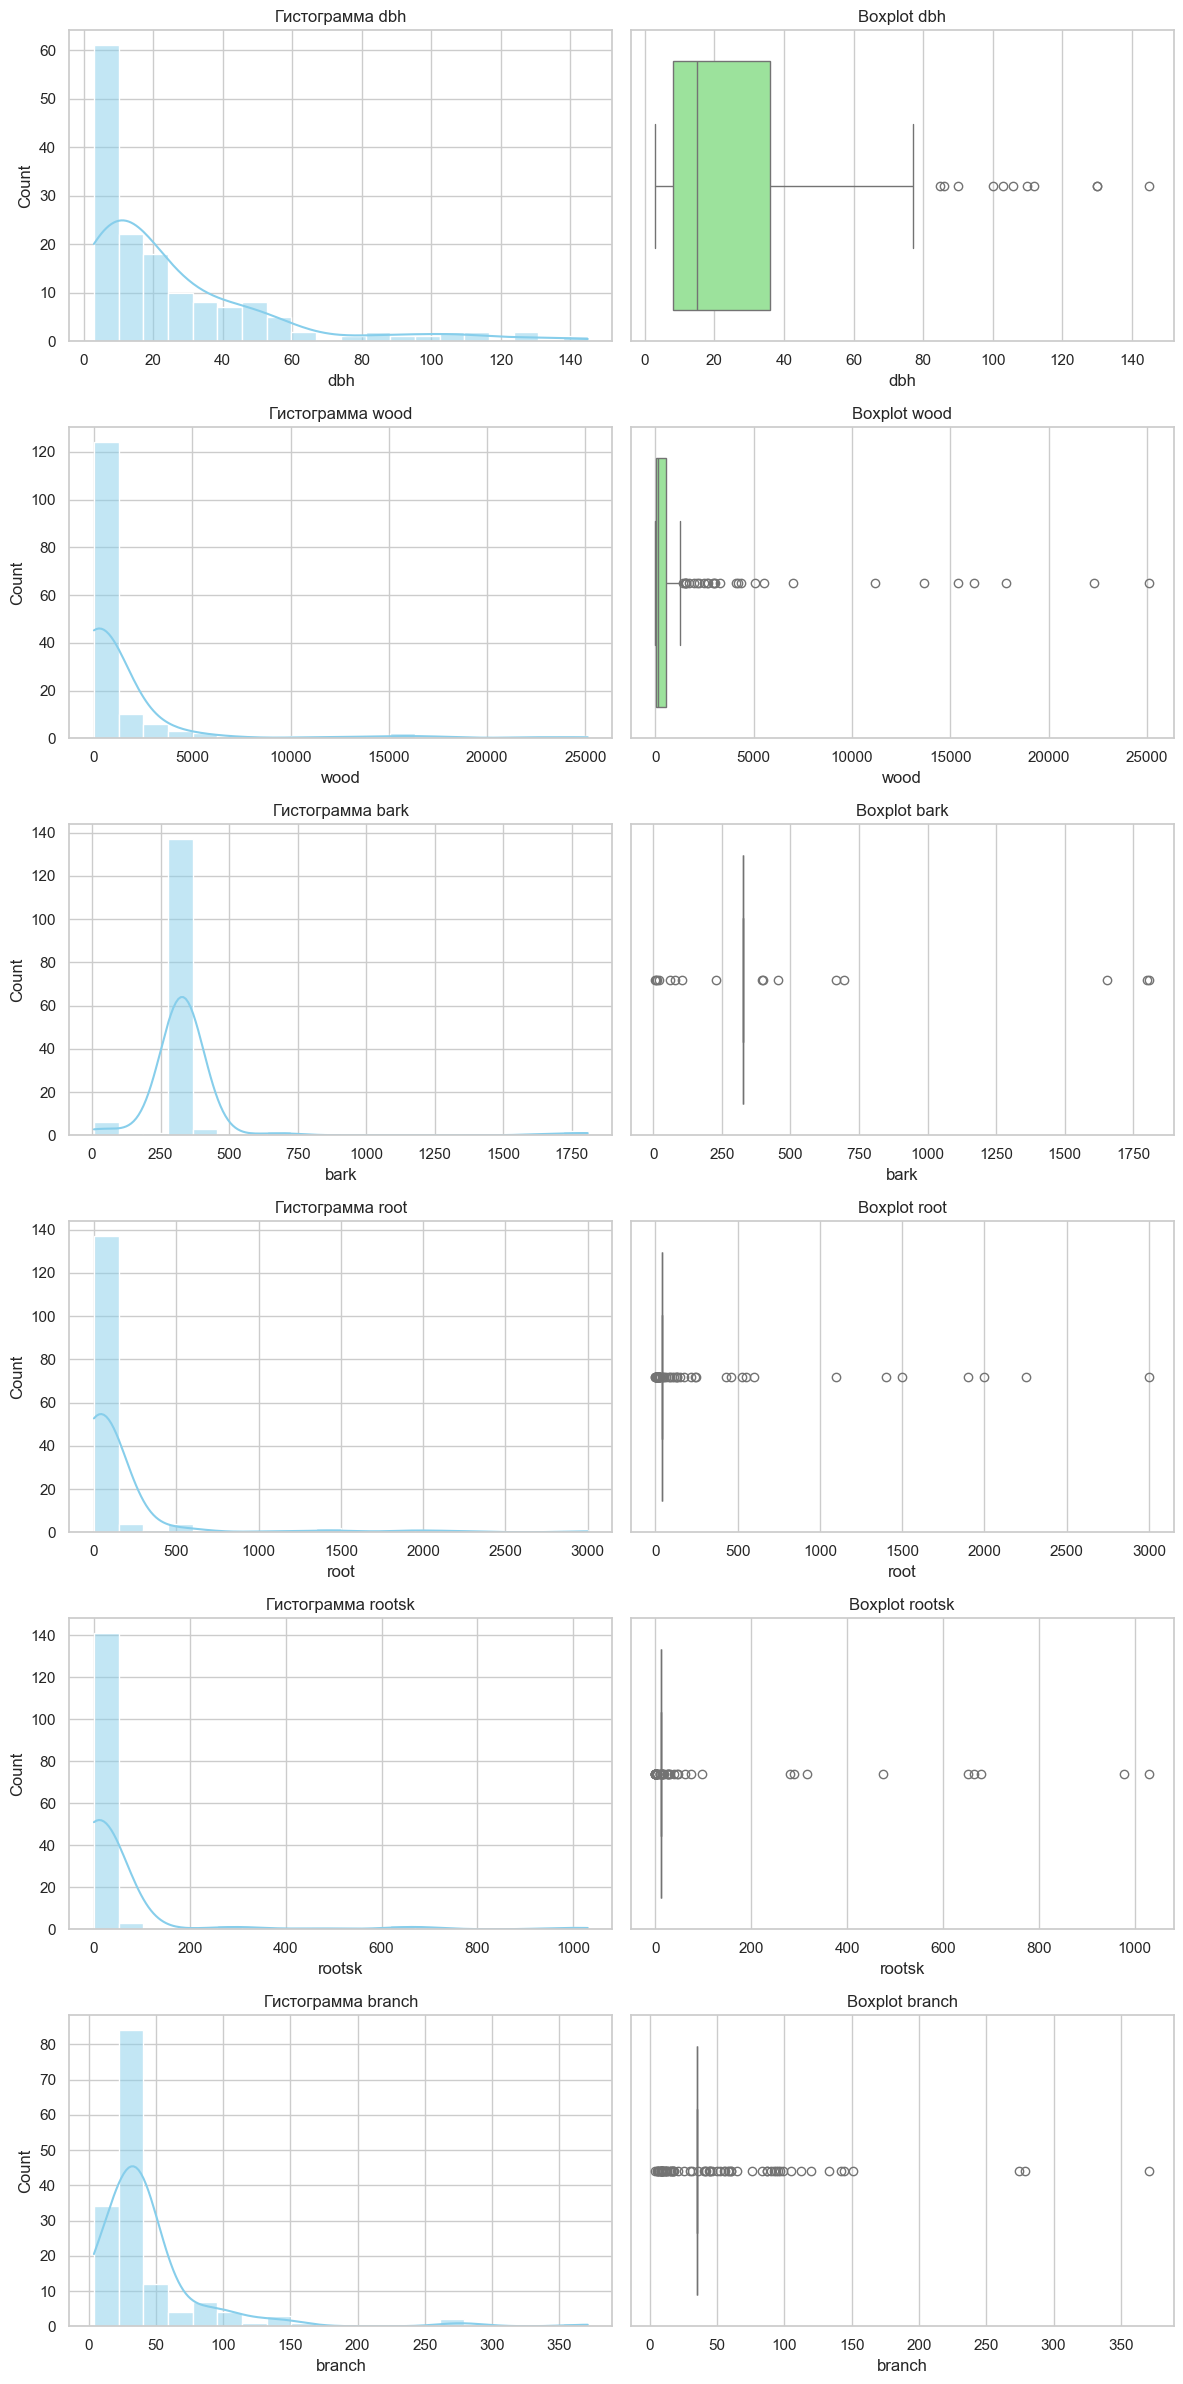

In [10]:
n = len(numeric_cols)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i,0], color='skyblue')
    axes[i,0].set_title(f'Гистограмма {col}')
    sns.boxplot(x=df[col], ax=axes[i,1], color='lightgreen')
    axes[i,1].set_title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

Распределения признаков визуализированы: можно оценить форму, наличие выбросов, вариативность и особенности каждого.

## Корреляция между числовыми признаками

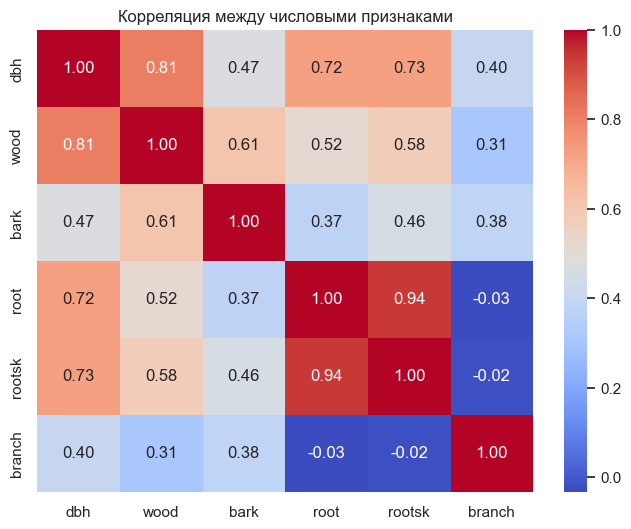

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между числовыми признаками')
plt.show()

Корреляция между числовыми признаками - позволяет выявить связанные признаки для сокращения размерности и оптимизации будущих моделей.

## Краткие выводы по EDA

- Датасет успешно обработан, основные признаки заполнены и структурированы.
- Пропусков в ключевых столбцах и дубликатов нет.
- Категориальные признаки сбалансированы, покрывают достаточное число видов.
- Выбросы обнаружены лишь в отдельных столбцах — требуют дальнейшего анализа.
- Распределения и корреляции свидетельствуют о качестве структуры для последующих задач.

Рекомендации:  
- Дальнейшее моделирование проводить после финальной проверки выбросов.
- Категориальные признаки при необходимости агрегировать.
- Все показатели метрик указывают на высокое качество исходных данных.

# Дополнительные визуализации для EDA

В этом разделе приведены разнообразные графики с помощью Seaborn.  
Каждая визуализация сопровождается пояснениями.  
Использован единый стиль (параметры set_theme и rcParams), графики выведены в сетке.

Настраиваем единый стиль палитры, сетку и размер шрифта для всех графиков

In [16]:
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.2)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


## Violin plot и Swarm plot: сравнение распределений

Violin plot позволяет визуализировать форму распределения числового признака по категориям.
Swarm plot показывает плотность объектов и индивидуальные точки, что удобно для диагностики выбросов и групп.

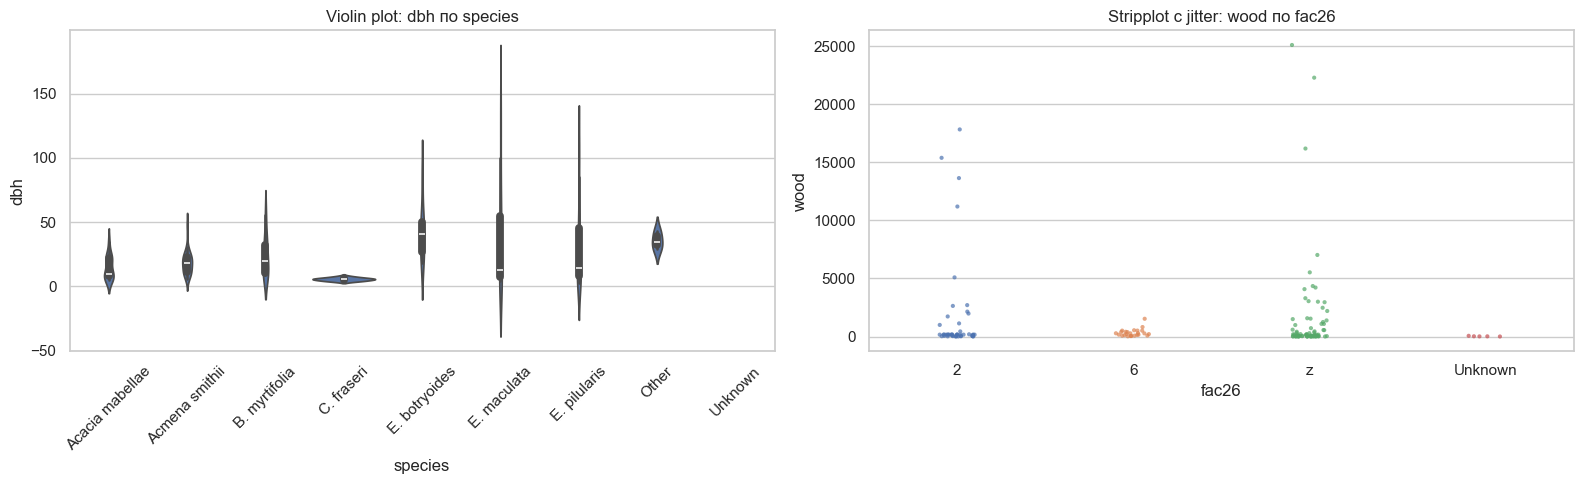

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.violinplot(x="species", y="dbh", data=df, ax=axes[0])
axes[0].set_title("Violin plot: dbh по species")
axes[0].tick_params(axis='x', rotation=45)

sns.stripplot(
    x="fac26", y="wood", hue="fac26", data=df, ax=axes[1],
    palette="deep", jitter=True, size=3, alpha=0.7, dodge=False, legend=False
)

axes[1].set_title("Stripplot с jitter: wood по fac26")

plt.tight_layout()
plt.show()

## KDE plot (плотности) по видам

KDE plot отражает вероятностную плотность распределения признака, удобно сравнивать различные группы между собой.


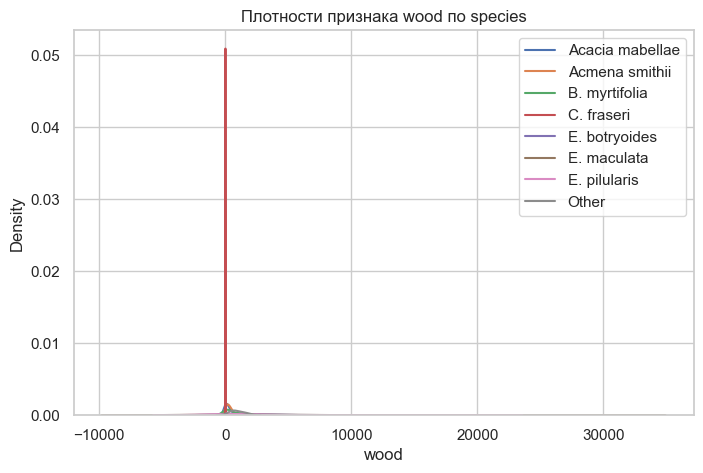

In [11]:
plt.figure(figsize=(8,5))
for s in df['species'].cat.categories:
    mask = df['species'] == s
    if mask.any():
        sns.kdeplot(df.loc[mask, "wood"], label=s)
plt.title("Плотности признака wood по species")
plt.xlabel("wood")
plt.legend()
plt.show()


## FacetGrid: boxplot dbh по species и fac26

Сетка из boxplot и facet позволяет изучать различия между подгруппами сразу по двум категориальным переменным.


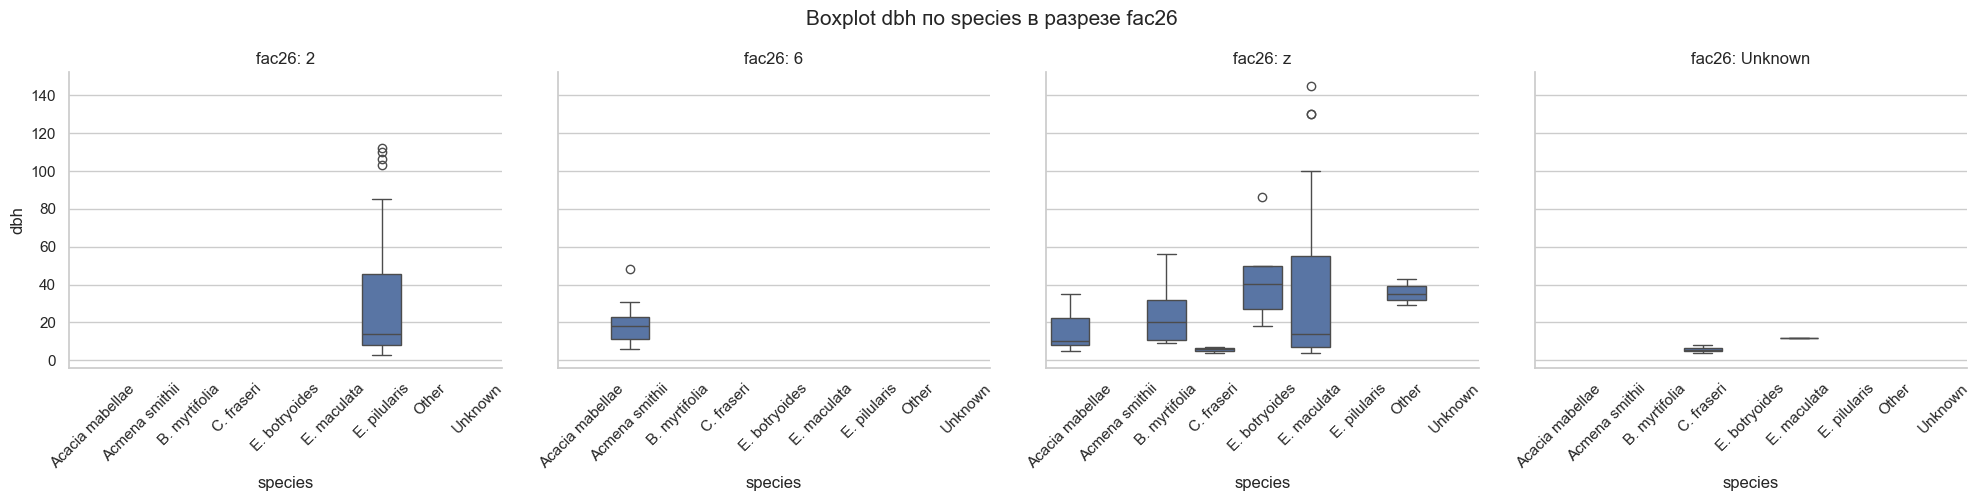

In [12]:
g = sns.FacetGrid(df, col="fac26", height=4, aspect=1.25, sharey=True)
g.map(sns.boxplot, "species", "dbh", order=df['species'].cat.categories)
g.set_titles('fac26: {col_name}')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.suptitle('Boxplot dbh по species в разрезе fac26', fontsize=15, y=1.06)
plt.show()


## Интерактивная визуализация с Plotly Express

Ниже представлены примеры динамических графиков с помощью Plotly Express.
Они интерактивны: поддерживают zoom, навигацию и всплывающие подсказки.


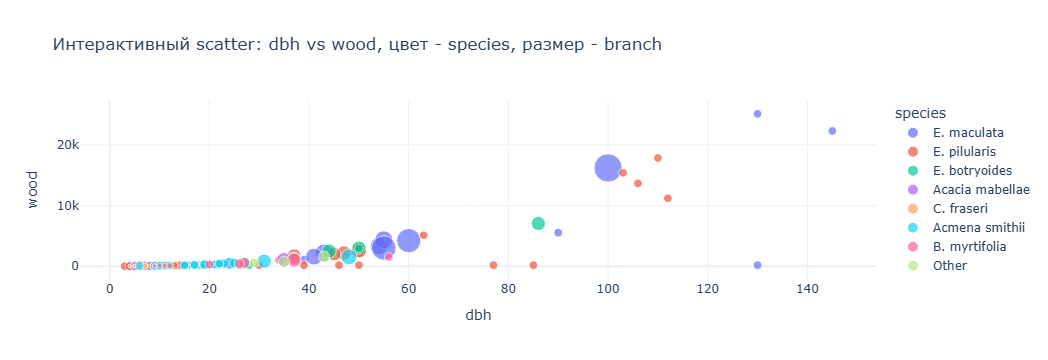

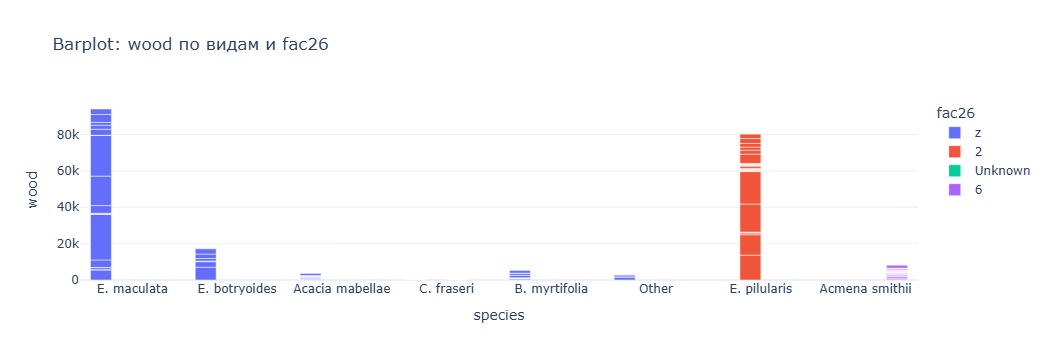

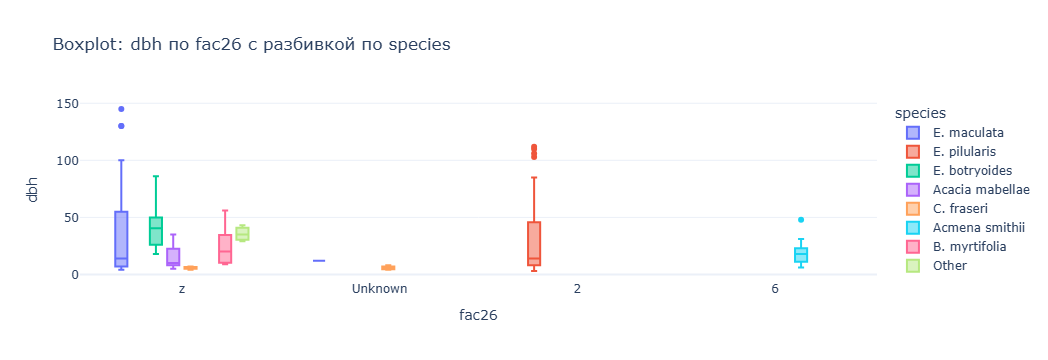

In [17]:
import plotly.express as px

fig1 = px.scatter(
    df, 
    x='dbh', 
    y='wood',
    color='species',
    size='branch',
    hover_data=['fac26'],
    title='Интерактивный scatter: dbh vs wood, цвет - species, размер - branch',
    template='plotly_white'
)
fig1.show()

fig2 = px.bar(
    df,
    x='species',
    y='wood',
    color='fac26',
    title='Barplot: wood по видам и fac26',
    template='plotly_white',
    barmode='group'
)
fig2.show()

fig3 = px.box(
    df, 
    x="fac26", 
    y="dbh", 
    color="species",
    title='Boxplot: dbh по fac26 с разбивкой по species',
    template='plotly_white'
)
fig3.show()


### Вывод

- Представлены различные типы графиков Seaborn: «скрипичный», «роевой», KDE, «ящик с усами» (FacetGrid).
- Все графики выполнены в едином стиле и с единой сеткой.
- В ноутбуке уже были гистограммы, ящичковые диаграммы и точечные диаграммы, но эти дополнения вносят разнообразие, создают единую сетку и стиль.
- Plotly Express добавляет к EDA интерактивность, позволяя быстро анализировать зависимости, распределения и выполнять визуальный drill-down по категориям.
